# Part 3: Deep Learning Model with Transformers
## Author: Brady Lamson
## Date: Fall 2023
# Overview and Motivation

This portion of the project has a couple distinct goals. 

Firstly, I shall utilize the `distilibert-base-uncased` model to attempt to predict the primary and secondary types of pokemon entirely from their text descriptions.

Secondly, this notebook will function as a detailed walkthrough to fine tuning a huggingface transformer. Much of the information for this task is scattered throughout documentation and articles of varying levels of utility, so compiling all of that information into one notebook will result in something that will hopefully be useful to me and anyone who may read this. 

This walkthrough will also utilize hyperparameter search using the `optuna` library, which many articles I have read online seem to lack. I hope this will give this walkthrough a useful niche that other guides have not filled.

## References

As I've never done multi-label classification using `transformers` before I'll be using [this guide by Ronak Patel](https://colab.research.google.com/github/rap12391/transformers_multilabel_toxic/blob/master/toxic_multilabel.ipynb#scrollTo=CQQ7CoOag_r7) that is featured in [towardsdatascience](https://towardsdatascience.com/transformers-for-multilabel-classification-71a1a0daf5e1). I won't be following it 1:1 but it's there to help me get some traction.

## Potential Limitations

Performance of this model will be sought after but is not the end goal. I fear that the dataset I am working with will put a cap on performance. Pokemon types are extremely varied, with 19 types existing in this dataset alone. On top of that, I am predicting on both primary and secondary types which turns this into a multi-label prediction problem. Thus, combinations of types become important and many combinations of types only appear once. This is a limitation that likely cannot be overcome without removing problematic rows from the training split or simply acquiring more data. 

A future improvement that is outside the scope of this project is to collect all of the pokemon descriptions from each game. There are many pokemon games, and using this would allow us to duplicate many pokemon and artifically make certain type combinations more frequent and inflate our dataset. This would also provide more descriptions to train on as they tend to be similar but not identical in every game. This is obviously not without its downsides as it would inflate the frequency of already frequent type combinations, but a variant of this plan with a bit more thought put into it may be worth considering if maximizing model performance is a priority.

# Data Loading and Preprocessing

Our goal here is to do the same pre-processing as in part 2. So we'll have a bit of a repeat of that content.
From there we'll need to convert our dataset to the transformers `DatasetDict` which will contain all of our splits. The big difference here is taking our same dataframe and doing what we need to do to it to get it working within the transforers framework.

Important note that here we do NOT remove stopwords from our text as BERT in particular benefits from the full context of the string.

In [1]:
import pandas as pd
import numpy as np
import os
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

# Set seed
np.random.seed(776)

cpu


In [2]:
data_path = "./data/pokemon.csv"
data_exists = os.path.isfile(data_path)

if not data_exists:
    # This part requires a kaggle api key. On linux this will be saved to your home directory in .kaggle/kaggle.json
    !kaggle datasets download -d cristobalmitchell/pokedex
    !unzip pokedex.zip -d data

df = (
    # load in the data
    pd.read_csv(data_path, sep='\t', encoding='utf-16-le')
    # select the relevant columns
    .loc[:, ['english_name', 'primary_type', 'secondary_type', 'description']]
    # Change the type columns into categories and handle NaNs in secondary typing
    .assign(
        primary_type=lambda x: x['primary_type'].astype("category"),
        secondary_type=lambda x: x['secondary_type'].fillna("none").astype("category")
    )
)
display(df.head())
display(df.info())
display(df.describe())

,english_name,primary_type,secondary_type,description
0,Bulbasaur,grass,poison,There is a plant seed on its back right from t...
1,Ivysaur,grass,poison,"When the bulb on its back grows large, it appe..."
2,Venusaur,grass,poison,Its plant blooms when it is absorbing solar en...
3,Charmander,fire,none,It has a preference for hot things. When it ra...
4,Charmeleon,fire,none,"It has a barbaric nature. In battle, it whips ..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   english_name    898 non-null    object  
 1   primary_type    898 non-null    category
 2   secondary_type  898 non-null    category
 3   description     898 non-null    object  
dtypes: category(2), object(2)
memory usage: 17.3+ KB


None

,english_name,primary_type,secondary_type,description
count,898,898,898,898
unique,898,18,19,896
top,Bulbasaur,water,none,Although it’s alien to this world and a danger...
freq,1,123,429,3


## Vectorize Categorical Data

Here we'll do the same one-hot encoding as in part 2. Here we'll do it before the splits though as, in retrospect, doing this after the split made no sense. 

In [3]:
names = list(df.secondary_type.unique())
id2label = {i: label for i, label in enumerate(names)}
label2id = {label: i for i, label in enumerate(names)}

def map_types(row):
    type_encoding = [0] * len(names)
    primary_id = label2id[row['primary_type']]
    secondary_id = label2id[row['secondary_type']]

    type_encoding[primary_id] = 1
    type_encoding[secondary_id] = 1
    
    # return [primary_id, secondary_id]
    return type_encoding

df['labels'] = df.apply(lambda row: map_types(row), axis=1)
df

,english_name,primary_type,secondary_type,description,labels
0,Bulbasaur,grass,poison,There is a plant seed on its back right from t...,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,Ivysaur,grass,poison,"When the bulb on its back grows large, it appe...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,Venusaur,grass,poison,Its plant blooms when it is absorbing solar en...,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,Charmander,fire,none,It has a preference for hot things. When it ra...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,Charmeleon,fire,none,"It has a barbaric nature. In battle, it whips ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
...,...,...,...,...,...
893,Regieleki,electric,none,This Pokémon is a cluster of electrical energy...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
894,Regidrago,dragon,none,An academic theory proposes that Regidrago’s a...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
895,Glastrier,ice,none,Glastrier emits intense cold from its hooves. ...,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
896,Spectrier,ghost,none,It probes its surroundings with all its senses...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [4]:
print(df.iloc[0]["primary_type"])
print(df.iloc[0]["secondary_type"])
print(df.iloc[0]["labels"])

grass
poison
[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Sanity Check: Verify our Preprocessing and Mapping Worked

In [5]:
for index, row in df.head().iterrows():
    actual_primary = row["primary_type"]
    actual_secondary = row["secondary_type"]
    mapped_types = [i for i, x in enumerate(row["labels"]) if x == 1]
    mapped_primary = id2label[mapped_types[0]]
    mapped_secondary = id2label[mapped_types[1]]

    print(f"Actual: {actual_primary}, {actual_secondary}")
    print(f"Mapped: {mapped_primary}, {mapped_secondary}\n")

Actual: grass, poison
Mapped: poison, grass

Actual: grass, poison
Mapped: poison, grass

Actual: grass, poison
Mapped: poison, grass

Actual: fire, none
Mapped: none, fire

Actual: fire, none
Mapped: none, fire



## Split The Dataset and Create DatasetDict

In [6]:
from sklearn.model_selection import train_test_split

# This provides a 70/15/15 split
train, test = train_test_split(df, test_size=0.3, random_state=10)
test, val = train_test_split(test, test_size=0.5, random_state=10)

Now what we want to do is convert this into a format transformers can work with, the `Dataset` object. It's just another way of storing data is all, nothing scary. We use their `Dataset.from_pandas()` method to easily convert and provide some additional information. Really the only important part here is specifying that the labels are a "Sequence" of "ClassLabels". Or, in laymens terms, a list of class ids.

Then we just use a larger container `DatasetDict` to easily store all 3 of our splits. So we don't have to juggle 5000 million different objects. 

In [7]:
from datasets import (
    Dataset, DatasetDict, Features,
    ClassLabel, Value, Sequence
)
from transformers import AutoTokenizer

In [8]:
def create_dataset(split: pd.DataFrame, mapper: dict) -> Dataset:
    """
    Converts a pandas dataframe into a Dataset object
    keeps only a handful of the columns I care about
    """
    
    names = list(mapper.keys())
    ds = Dataset.from_pandas(
        df = split[['english_name', 'description', 'labels']],
        features = Features({
            "english_name": Value(dtype="string"),
            "description": Value(dtype="string"),
            'labels': Sequence(
                feature=Value(dtype="float32"),
                length=len(names)
            ),
            "__index_level_0__": Value(dtype="int64")
        })
    )

    return ds

In [9]:
ds = DatasetDict({
    "train": create_dataset(train, label2id),
    "test": create_dataset(test, label2id),
    "val": create_dataset(val, label2id)
})

ds

DatasetDict({
    train: Dataset({
        features: ['english_name', 'description', 'labels', '__index_level_0__'],
        num_rows: 628
    })
    test: Dataset({
        features: ['english_name', 'description', 'labels', '__index_level_0__'],
        num_rows: 135
    })
    val: Dataset({
        features: ['english_name', 'description', 'labels', '__index_level_0__'],
        num_rows: 135
    })
})

In [10]:
# Exampe row
ds["train"][0]

{'english_name': 'Wartortle',
 'description': 'It is recognized as a symbol of longevity. If its shell has algae on it, that Wartortle is very old.',
 'labels': [0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0],
 '__index_level_0__': 7}

## Tokenize Pokedex Description

And now we use a pretrained tokenizer using the same name as what our model will use later. This tokenizer is extremely convenient and allows us to focus on other work. Though we'll want to check it's work to make sure it isn't doing any bizarre.

The `Dataset` object comes with a convenient `map` method for applying functions across all its splits. 

The tokenizer adds 2 new columns, `input_ids` and `attention_mask`. The former is simply the tokenized version of the provided text, the latter specifies where special tokens are to allow the model to properly ignore them. A tokenier may or may not provide columns beyond this as well depending on the downstream task being used, so keep an eye out for how your dataset changes and be sure it changes how it should! 

In [11]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_description(example):
    tokenized_desc = tokenizer(example['description'], padding='max_length', is_split_into_words=False, max_length=60)

    return tokenized_desc

ds = ds.map(
    lambda example: tokenize_description(example)
)

Map:   0%|          | 0/628 [00:00<?, ? examples/s]

Map:   0%|          | 0/135 [00:00<?, ? examples/s]

Map:   0%|          | 0/135 [00:00<?, ? examples/s]

In [12]:
# Take note of the new features
ds["train"]

Dataset({
    features: ['english_name', 'description', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 628
})

### Verify tokenizer worked as intended

In [13]:
first_row = ds["train"][0]
print(tokenizer.decode(first_row["input_ids"], skip_special_tokens=True))
print(first_row["description"])

it is recognized as a symbol of longevity. if its shell has algae on it, that wartortle is very old.
It is recognized as a symbol of longevity. If its shell has algae on it, that Wartortle is very old.


### Verify equality of lengths

This is a quick visual sanity check I like to do. I want to make sure everything has been padded correctly because inequalities here can cause issues.

In [14]:
for index, example in enumerate(ds['train']):
    if index < 5:
        input_ids_length = len(example['input_ids'])
        attention_mask_length = len(example['attention_mask'])
        
        # Print the lengths for each feature in this row
        print(f'Input IDs Length: {input_ids_length}')
        print(f'Attention Mask Length: {attention_mask_length}\n')

lengths = [len(row["input_ids"]) for row in ds["train"]]
max(lengths)

Input IDs Length: 60
Attention Mask Length: 60

Input IDs Length: 60
Attention Mask Length: 60

Input IDs Length: 60
Attention Mask Length: 60

Input IDs Length: 60
Attention Mask Length: 60

Input IDs Length: 60
Attention Mask Length: 60



60

In [15]:
ds.set_format("torch")

# Building the Trainer

The key to fine tuning with the transformers library is understanding that it all revolves around the `Trainer` object. All of what we're building here will all eventually plug into it. 

We need the following

- A `compute_metrics()` function for evaluating performance
- A `TrainingArguments` object
- An `init_model()` function for use with hyperparameter search
- A hyperparameter space object for use with, uh, also hyperparameter search
- The `Trainer` object itself

In [16]:
from transformers import (
    AutoModelForSequenceClassification, TrainingArguments, Trainer
)

## Metric Evaluator

Below is code modified from [this notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb). I had to tweak stuff like changing sigmoid to softmax and adding in my own custom function for extracting the top 2 predictions. Many examples utilize a threshold but due to the large number of classes I feel like that's not a good fit for this model. 

Gonna be honest here, mostly taking these metrics at face-value. Stuff gets weird in multi-label models and I had a lot of trouble figuring this out on my own. 

In [55]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
from torch.nn.functional import softmax
from torch import tensor, topk

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply softmax to our logits to get our probabilities
    probs = softmax(torch.Tensor(predictions), dim=0)

    def tensor_to_indices(tensor):
        # Here this function takes a tensor of probabilities and returns the indices of the two highest probs
        _, indices = topk(tensor, 2)
        indices = indices.tolist()
    
        return sorted(indices)
    
    # next, use said indices to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    pred_indices = tensor_to_indices(probs)
    for index, row in enumerate(y_pred):
        row[pred_indices[index]] = 1
    
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics


def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

## Model Initializer

In [18]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=len(names), 
        problem_type="multi_label_classification", 
        id2label=id2label, 
        label2id=label2id
    )

In [19]:
# num_labels = len(label2id.keys())
# model = AutoModelForSequenceClassification.from_pretrained(
#     model_name, num_labels=len(names), problem_type="multi_label_classification", id2label=id2label, label2id=label2id
# )
# model

## Training Arguments and Trainer

Here we set up our training arguments for hyperparameter search specifically. There'll be some slight differences to how we finally train the model. The big difference here is that I won't be saving checkpoint models for the search. This drastically increases training time and, as this is for class, it isn't worth the effort. Saving checkpoint models for each and every trial also nukes my poor hard drive as I have to save countless 500MB+ models.

In [28]:
training_arguments = TrainingArguments(
    output_dir="models",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_strategy="epoch",
    evaluation_strategy='epoch',
    metric_for_best_model="eval_loss",
    save_strategy="no",
    push_to_hub=False,
    remove_unused_columns=False
)

cols_to_train_on = ["input_ids", "attention_mask", "labels"]

trainer = Trainer(
    model=None,
    model_init=model_init,
    args=training_arguments,
    train_dataset=ds["train"].select_columns(cols_to_train_on),
    eval_dataset=ds["val"].select_columns(cols_to_train_on),
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Hyperparameter Search

What's neat about the `Trainer` is that it has a built in hyperparmeter search method we can leverage. To do so though we need to use a supported 3rd party library `optuna` to build a **hyperparameter space**. This is just a simple dictionary that specifies what parameters we'll be tweaking and how. 

## Hyperparamter Values

As for hyperparameter values, I'll be leaning on stackexchange's user Mon for recommendedations and using [this thread they contributed to](https://datascience.stackexchange.com/questions/64583/what-are-the-good-parameter-ranges-for-bert-hyperparameters-while-finetuning-it) as a guide.

### Epochs

For LLMs smaller amounts of epochs are recommended and so I'll be using less than 20 of these. This will also reduce training time and allow me to get this project out the door faster.

### Batch Size

I'll be using values less than 32 here, but this will require some tinkering as values too large can sometimes devour VRAM and kill the process. This in particular will depend on the size of the tokenized text and the power of the computer used for training. The values we go with here will both need to work and also be the best performing values. 

### Learning Rate

We'll be sticking with values hovering around $2e^{-5}$ here as values "larger" can start to make the model forget too much of its original weights/biases and damage its performance. 

## Hyperparameter Space

Now we build the object and pass in the appropriate values

In [23]:
import optuna

def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 2e-5, 5e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "per_device_eval_batch_size": trial.suggest_categorical("per_device_eval_batch_size", [8, 16, 32])
    }


## Hyperparameter Search

Small note, `direction` here will depend on what you choose for the training argument `metric_for_best_model`. I'm using the loss so we want to minimize that. This will change if you want to maximize fscore as an example. 

In [29]:
best_trial = trainer.hyperparameter_search(
    direction="minimize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=5
)

best_trial

[I 2023-12-03 14:20:41,827] A new study created in memory with name: no-name-41bac3cb-ff8a-4191-9413-7a98d218822a
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.528500,0.408230,0.296846,0.607323,0.022222
2,0.369300,0.333789,0.293135,0.605246,0.037037
3,0.323000,0.312780,0.300557,0.609399,0.051852
4,0.312100,0.308287,0.300557,0.609399,0.051852
5,0.310200,0.307590,0.300557,0.609399,0.051852
6,0.308500,0.307546,0.300557,0.609399,0.051852
7,0.306200,0.306434,0.300557,0.609399,0.051852
8,0.307200,0.305267,0.300557,0.609399,0.051852
9,0.303000,0.303760,0.300557,0.609399,0.051852
10,0.302900,0.303412,0.296846,0.607323,0.044444


[I 2023-12-03 14:22:54,877] Trial 0 finished with value: 0.948613033714325 and parameters: {'learning_rate': 4.4674455649180644e-05, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 16}. Best is trial 0 with value: 0.948613033714325.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.577300,0.468150,0.270872,0.592787,0.029630
2,0.424700,0.383600,0.293135,0.605246,0.000000
3,0.365500,0.344305,0.300557,0.609399,0.051852
4,0.337400,0.325920,0.300557,0.609399,0.051852
5,0.324600,0.317556,0.300557,0.609399,0.051852
6,0.317100,0.313639,0.300557,0.609399,0.051852
7,0.312700,0.311492,0.300557,0.609399,0.051852
8,0.313200,0.310451,0.300557,0.609399,0.051852
9,0.310200,0.309786,0.300557,0.609399,0.051852
10,0.311100,0.309695,0.300557,0.609399,0.051852


[I 2023-12-03 14:25:07,294] Trial 1 finished with value: 0.9618075223552018 and parameters: {'learning_rate': 2.6548446161766417e-05, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 32}. Best is trial 0 with value: 0.948613033714325.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.584000,0.476805,0.263451,0.588634,0.014815
2,0.433100,0.391754,0.296846,0.607323,0.007407
3,0.373400,0.351240,0.296846,0.607323,0.037037
4,0.343400,0.330803,0.300557,0.609399,0.051852
5,0.328900,0.320986,0.300557,0.609399,0.051852
6,0.320200,0.316007,0.300557,0.609399,0.051852
7,0.315100,0.313289,0.300557,0.609399,0.051852
8,0.315100,0.311928,0.300557,0.609399,0.051852
9,0.311700,0.311093,0.300557,0.609399,0.051852
10,0.312600,0.310938,0.300557,0.609399,0.051852


[I 2023-12-03 14:27:21,109] Trial 2 finished with value: 0.9618075223552018 and parameters: {'learning_rate': 2.4649810021998845e-05, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 8}. Best is trial 0 with value: 0.948613033714325.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.600500,0.499678,0.267161,0.590711,0.014815
2,0.454800,0.412481,0.289425,0.603170,0.022222
3,0.393200,0.369325,0.300557,0.609399,0.007407
4,0.360200,0.345708,0.300557,0.609399,0.051852
5,0.342700,0.332743,0.300557,0.609399,0.051852
6,0.331200,0.325303,0.300557,0.609399,0.051852
7,0.324000,0.320867,0.300557,0.609399,0.051852
8,0.322400,0.318396,0.300557,0.609399,0.051852
9,0.318300,0.316981,0.300557,0.609399,0.051852
10,0.318600,0.316629,0.300557,0.609399,0.051852


[I 2023-12-03 14:29:34,997] Trial 3 finished with value: 0.9618075223552018 and parameters: {'learning_rate': 2.0351238507399576e-05, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 8}. Best is trial 0 with value: 0.948613033714325.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.466700,0.346742,0.300557,0.609399,0.014815
2,0.323200,0.310571,0.300557,0.609399,0.051852
3,0.309500,0.307342,0.300557,0.609399,0.051852
4,0.308800,0.304680,0.300557,0.609399,0.051852
5,0.302500,0.300017,0.296846,0.607323,0.037037
6,0.292100,0.293121,0.296846,0.607323,0.051852
7,0.276400,0.287479,0.300557,0.609399,0.051852
8,0.262900,0.283659,0.296846,0.607323,0.029630
9,0.251700,0.280379,0.289425,0.603170,0.044444
10,0.243300,0.280257,0.296846,0.607323,0.044444


[I 2023-12-03 14:32:18,801] Trial 4 finished with value: 0.948613033714325 and parameters: {'learning_rate': 3.8659649840422755e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 32}. Best is trial 0 with value: 0.948613033714325.


BestRun(run_id='0', objective=0.948613033714325, hyperparameters={'learning_rate': 4.4674455649180644e-05, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 16}, run_summary=None)

So if you take the time to look at this output you may notice something bad (and hilarious), all of these models converge to the same crappy point. They all suck in the same way. This search did NOTHING. It doesn't seem like more epochs would help either, it converges in accuracy by epoch 4 on some of these. So uh, a deeper look into what parameters to change or even the metric calculation is in order. There is something fundamentally bad about how I've approached this problem.

## Extract Best Parameters

In [30]:
best_params = best_trial.hyperparameters
best_params

{'learning_rate': 4.4674455649180644e-05,
 'per_device_train_batch_size': 32,
 'per_device_eval_batch_size': 16}

## Clear GPU Cache

There can be a lot of residual GPU memory taken up after this process, so we clear out the cache after we get the values we need.

In [31]:
from torch.cuda import empty_cache

if device == 'cuda':
    empty_cache()

# Training With Best Parameters

Now we set stuff up proper taking note of all the differences now. 

We do setup saving and set a max for the number of models that can be saved. I also setup an early stopping procedure to help prevent overfitting.

In [56]:
from transformers import EarlyStoppingCallback

training_arguments = TrainingArguments(
    output_dir="models",
    learning_rate=best_params['learning_rate'],
    per_device_train_batch_size=best_params['per_device_train_batch_size'],
    per_device_eval_batch_size=best_params['per_device_eval_batch_size'],
    num_train_epochs=10,
    weight_decay=0.1,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=7,
    remove_unused_columns=False,
    load_best_model_at_end=True
)

cols_to_train_on = ["input_ids", "attention_mask", "labels"]

trainer = Trainer(
    model=None,
    model_init=model_init,
    args=training_arguments,
    train_dataset=ds["train"].select_columns(cols_to_train_on),
    eval_dataset=ds["val"].select_columns(cols_to_train_on),
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.528500,0.408272,0.115028,0.505574,0.007407
2,0.369300,0.333810,0.115028,0.505574,0.007407
3,0.323000,0.312832,0.111317,0.503497,0.007407
4,0.312100,0.308321,0.126160,0.511803,0.014815
5,0.310200,0.307632,0.137291,0.518033,0.022222
6,0.308500,0.307586,0.115028,0.505574,0.007407
7,0.306200,0.306489,0.122449,0.509727,0.000000
8,0.307200,0.305316,0.100186,0.497268,0.007407
9,0.303000,0.303793,0.111317,0.503497,0.014815
10,0.302900,0.303436,0.118738,0.507650,0.000000


TrainOutput(global_step=200, training_loss=0.33709766149520876, metrics={'train_runtime': 144.8372, 'train_samples_per_second': 43.359, 'train_steps_per_second': 1.381, 'total_flos': 97517281636800.0, 'train_loss': 0.33709766149520876, 'epoch': 10.0})

# Model Evaluation

## Examining Training Logs

In [58]:
import pandas as pd
from matplotlib import pyplot as plt

train_logs = []
valid_logs = []
for index, x in enumerate(trainer.state.log_history):
    if 'loss' in x.keys():
        train_logs.append(x)
    elif 'eval_loss' in x.keys():
        valid_logs.append(x)
    else:
        pass

train_logs = pd.DataFrame(train_logs)
valid_logs = pd.DataFrame(valid_logs)

display(train_logs)
display(valid_logs)

,loss,learning_rate,epoch,step
0,0.5285,0.000040,1.0,20
1,0.3693,0.000036,2.0,40
2,0.3230,0.000031,3.0,60
3,0.3121,0.000027,4.0,80
4,0.3102,0.000022,5.0,100
5,0.3085,0.000018,6.0,120
6,0.3062,0.000013,7.0,140
7,0.3072,0.000009,8.0,160
8,0.3030,0.000004,9.0,180
9,0.3029,0.000000,10.0,200


,eval_loss,eval_f1,eval_roc_auc,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.408272,0.115028,0.505574,0.007407,0.8514,158.566,10.571,1.0,20
1,0.333810,0.115028,0.505574,0.007407,0.8470,159.388,10.626,2.0,40
2,0.312832,0.111317,0.503497,0.007407,0.8528,158.310,10.554,3.0,60
3,0.308321,0.126160,0.511803,0.014815,0.8441,159.931,10.662,4.0,80
4,0.307632,0.137291,0.518033,0.022222,0.8597,157.026,10.468,5.0,100
5,0.307586,0.115028,0.505574,0.007407,0.8554,157.814,10.521,6.0,120
6,0.306489,0.122449,0.509727,0.000000,0.8561,157.697,10.513,7.0,140
7,0.305316,0.100186,0.497268,0.007407,0.8594,157.088,10.473,8.0,160
8,0.303793,0.111317,0.503497,0.014815,0.8539,158.100,10.540,9.0,180
9,0.303436,0.118738,0.507650,0.000000,0.8512,158.594,10.573,10.0,200


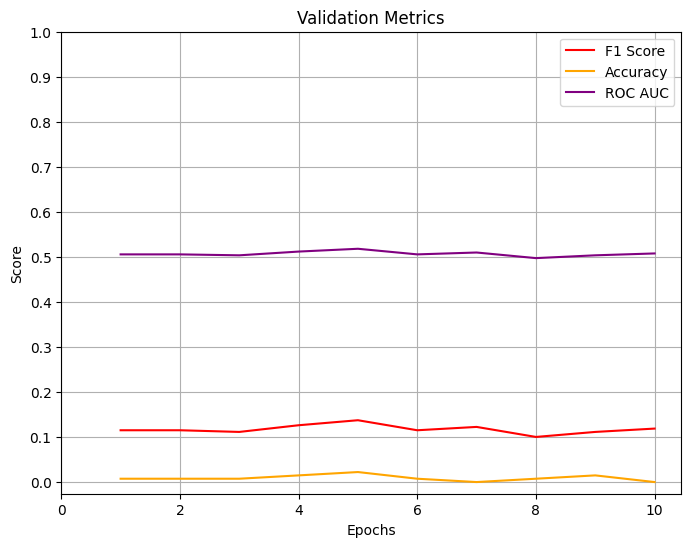

In [59]:
plt.figure(figsize=(8,6))
plt.plot(valid_logs.epoch, valid_logs.eval_f1, color='red', label='F1 Score')
plt.plot(valid_logs.epoch, valid_logs.eval_accuracy, color='orange', label='Accuracy')
plt.plot(valid_logs.epoch, valid_logs.eval_roc_auc, color='purple', label='ROC AUC')
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Validation Metrics")
plt.xticks(np.arange(0, 11, 2))
plt.yticks(np.arange(0,1.1,.1))
plt.legend()
plt.grid(True)


This is perhaps the funniest fine tuning plot I have ever seen in my life. This model sucks SO BAD. This is the funniest thing I have ever seen in my entire life I have never created something so hell-bent on refusing to improve. This is fantastic.

In [36]:
test_results = trainer.predict(ds["test"].select_columns(cols_to_train_on))

## Testing Metrics

In [37]:
test_results

PredictionOutput(predictions=array([[-2.3712327 , -0.31074724, -1.793147  , ..., -2.6443713 ,
        -2.2080014 , -1.9563926 ],
       [-2.2860775 , -0.24917479, -1.9477478 , ..., -2.8598552 ,
        -2.1890223 , -2.0565896 ],
       [-2.313064  , -0.15123682, -2.1181304 , ..., -2.8251402 ,
        -2.2538269 , -2.1162133 ],
       ...,
       [-2.3708131 , -0.26421148, -1.9273932 , ..., -2.7729497 ,
        -2.2259245 , -2.0452256 ],
       [-2.355137  , -0.2656626 , -1.8036344 , ..., -2.736625  ,
        -2.1617198 , -1.9295585 ],
       [-2.362205  , -0.26113003, -1.9145846 , ..., -2.83908   ,
        -2.2564363 , -2.0735292 ]], dtype=float32), label_ids=array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.]], dtype=float32), metrics={'test_loss': 0.28956642746925354, 'test_f1': 0.37407407407407406, 

In [39]:
test_results.metrics

{'test_loss': 0.28956642746925354,
 'test_f1': 0.37407407407407406,
 'test_roc_auc': 0.6502178649237472,
 'test_accuracy': 0.08888888888888889,
 'test_runtime': 0.98,
 'test_samples_per_second': 137.754,
 'test_steps_per_second': 9.184}

# Show Predictions (they're bad)

In [81]:
for index, logit in enumerate(test_results.predictions):
    if index < 10:
    
        probs = softmax(torch.Tensor(logit), dim=0)
    
        def tensor_to_indices(tensor):
            # Here this function takes a tensor of probabilities and returns the indices of the two highest probs
            _, indices = topk(tensor, 2)
            indices = indices.tolist()
        
            return sorted(indices)
    
        # Show pokemon name
        name = ds["test"]["english_name"][index]
        print(f"Pokemon: {name}")
    
        # convert true labels to types
        true_types = ds["test"]["labels"][index]
        true_types = tensor_to_indices(true_types)
        true_types = [id2label[index] for index in true_types]
        print(f"True: {true_types}")
        
        # Convert predictions to types
        pred_indices = tensor_to_indices(probs)
        pred_types = [id2label[index] for index in pred_indices]
        print(f"Predicted: {pred_types}")
        print("---")

Pokemon: Electabuzz
True: ['none', 'electric']
Predicted: ['none', 'flying']
---
Pokemon: Scolipede
True: ['poison', 'bug']
Predicted: ['none', 'water']
---
Pokemon: Cosmog
True: ['none', 'psychic']
Predicted: ['none', 'water']
---
Pokemon: Melmetal
True: ['none', 'steel']
Predicted: ['none', 'water']
---
Pokemon: Klefki
True: ['fairy', 'steel']
Predicted: ['none', 'flying']
---
Pokemon: Ducklett
True: ['flying', 'water']
Predicted: ['none', 'water']
---
Pokemon: Articuno
True: ['flying', 'ice']
Predicted: ['none', 'water']
---
Pokemon: Sandygast
True: ['ground', 'ghost']
Predicted: ['none', 'water']
---
Pokemon: Tyrogue
True: ['none', 'fighting']
Predicted: ['none', 'water']
---
Pokemon: Rookidee
True: ['none', 'flying']
Predicted: ['none', 'flying']
---


# Conclusion

It doesn't take a pokemon master to note that this model is terrible. It has similar issues as the part 2 model actually, it constantly predicts types we knew would be common. "None", "Water" and "Flying". It basically never deviates from this. Almost every single prediction contains none and one of those two types. I only show 10 of the predictions here but trust me, this behavior continues. 

I am baffled by how poorly this model performs and how little things changed during fine tuning. I believe I am missing something fundamental to how this type of problem should be tackled. I've never done multi label classification and it's very possible that I butchered the entire process. Is it how I handled the `None` types? Is it how I handled the labeling? The metric computataions are a likely suspect as well as that was code I took and modified and as such don't understand very well.

Oh well! I've never failed this horrendously on building a model before so it was very entertaining to see how things look when a model totally sucks. This was actually very insightful. I'm going to have to come back to this at a later date. 

Also I should have shown how to set up a pipeline and such but I don't believe it's necessary. I've gotten what I wanted out of this.